# Monte Carlo Simulations with the Efficient Frontier


## Summary of Efficient Frontier

 The Efficient fronter is a set of optimal portfolios that offer the highest expected return for a defined level of risk. It provides a great visualization on how to choose an optimal portfolio mathematically. *Risk is defined as the assests actual return differing from our expected return.*

## Summary

I will simulate weights on individual companies within a given portfolio to obtain an understanding on what return to risk is desired by the individual.

I picked 10 or so companies that are spread out in their corresponding Industries such that we have a relatively "low" correlation with each other.

## Companies
#### Google | NVIDIA | Facebook
#### Wells Fargo | Pfizer | COKE
#### Disney | IMAX | Catepillar
#### Southwest Airlines

In [1]:
import re
from io import StringIO
from datetime import datetime, timedelta
import requests
import pandas as pd
import numpy as np

In [2]:
import yfinance as yf
import pandas as pd
from datetime import datetime

def get_historical_data(tickers):
    """
    This function returns a pd dataframe with all of the adjusted closing information
    """
    data = pd.DataFrame()
    names = []
    for ticker in tickers:
        try:
            # Fetching the adjusted close prices directly using yfinance
            temp_data = yf.download(ticker, start="2017-10-11", end="2024-10-11")['Adj Close']
            data = pd.concat([data, temp_data], axis=1)
            names.append(ticker)
        except Exception as e:
            print(f"Error fetching data for {ticker}: {e}")
    data.columns = names
    return data

# Ticker names of the companies that we will be looking at
ticks = ["GOOG", "NVDA", "META", "WFC", "DIS", "IMAX", "LUV", "PFE", "COKE", "CAT"]

# Fetch the data
d = get_historical_data(ticks)

# Check the data dimensions
print(d.shape)

# Most recent data
print(d.tail())


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

(1761, 10)
                           GOOG        NVDA        META        WFC        DIS  \
2024-10-04 00:00:00  168.559998  124.919998  595.940002  56.959999  95.150002   
2024-10-07 00:00:00  164.389999  127.720001  584.780029  57.160000  92.389999   
2024-10-08 00:00:00  165.699997  132.889999  592.890015  57.299999  92.510002   
2024-10-09 00:00:00  163.059998  132.649994  590.510010  57.540001  93.599998   
2024-10-10 00:00:00  163.179993  134.809998  583.830017  57.750000  92.989998   

                      IMAX        LUV        PFE         COKE         CAT  
2024-10-04 00:00:00  19.51  31.250000  28.580000  1292.089966  397.089996  
2024-10-07 00:00:00  19.68  31.040001  29.200001  1257.280029  398.250000  
2024-10-08 00:00:00  19.41  30.670000  29.180000  1278.609985  387.959991  
2024-10-09 00:00:00  19.35  30.639999  30.190001  1276.459961  396.190002  
2024-10-10 00:00:00  20.17  30.360001  29.340000  1267.000000  396.640015  


In [3]:
# Saving the most recent year data such that we can compare...
# Called dT (DataTest)
dT = d.iloc[d.shape[0] - 252:,:] # Data test

# Update the "Training" or "data full"
d = d.iloc[:d.shape[0] - 252,:] # Data Train for the Simulation

print("Testing Data dimensions: ", dT.shape)
print("Training Data dimensions:", d.shape)

Testing Data dimensions:  (252, 10)
Training Data dimensions: (1509, 10)


In [4]:
dT # Test

,GOOG,NVDA,META,WFC,DIS,IMAX,LUV,PFE,COKE,CAT
2023-10-11,141.352859,46.791840,326.835968,38.547127,84.185974,18.700001,25.584131,31.265785,645.995972,268.102631
2023-10-12,139.946304,46.930798,323.186920,38.595688,83.689888,18.030001,24.851761,31.086365,614.716125,264.938416
2023-10-13,138.240494,45.447247,313.745361,39.780563,83.689888,17.740000,24.773640,30.321482,608.683472,263.297394
2023-10-16,140.145828,46.081062,320.185944,40.450691,85.039246,17.770000,25.007998,31.416874,619.573608,266.097992
2023-10-17,140.644608,43.924713,323.027405,40.771191,85.525406,17.990000,25.183769,30.925835,619.681274,267.925781
...,...,...,...,...,...,...,...,...,...,...
2024-10-04,168.559998,124.919998,595.940002,56.959999,95.150002,19.510000,31.250000,28.580000,1292.089966,397.089996
2024-10-07,164.389999,127.720001,584.780029,57.160000,92.389999,19.680000,31.040001,29.200001,1257.280029,398.250000
2024-10-08,165.699997,132.889999,592.890015,57.299999,92.510002,19.410000,30.670000,29.180000,1278.609985,387.959991
2024-10-09,163.059998,132.649994,590.510010,57.540001,93.599998,19.350000,30.639999,30.190001,1276.459961,396.190002


In [5]:
d # Train

,GOOG,NVDA,META,WFC,DIS,IMAX,LUV,PFE,COKE,CAT
2017-10-11,49.341328,4.718952,172.221466,45.459282,94.331490,21.450001,54.291416,26.154573,215.432434,109.345367
2017-10-12,49.270496,4.721175,172.032028,45.091751,92.780830,21.200001,54.532516,26.082823,214.613983,110.527245
2017-10-13,49.362778,4.809158,173.218460,43.850315,93.211563,21.150000,54.819958,26.075640,214.414200,111.139435
2017-10-16,49.478489,4.891704,173.996140,43.940155,93.929459,21.150000,54.597420,25.817331,216.127182,111.785637
2017-10-17,49.487469,4.887256,175.581345,43.441959,94.149628,20.500000,54.458324,25.975191,214.985123,110.994881
...,...,...,...,...,...,...,...,...,...,...
2023-10-04,135.936157,44.027679,304.662689,37.847862,78.699249,18.889999,26.560623,31.454643,631.668274,260.437805
2023-10-05,135.656860,44.674480,303.875092,38.168358,80.177589,19.040001,26.677801,31.605730,619.221008,256.281097
2023-10-06,138.390137,45.748161,314.483124,38.547127,82.290924,19.820000,26.443441,31.284670,628.847839,261.430298
2023-10-09,139.158249,45.259304,317.404327,38.556839,84.037148,19.450001,25.877079,31.350767,627.026245,266.599152


# Understanding Returns

In [15]:
from scipy import stats
expected_returns_a = d.pct_change() # Daily returns from trading day to day...
expected_returns_a.columns = ticks # Setting the Column names 
expected_returns_aA = pd.DataFrame(expected_returns_a.mean()*250) # Annualizing the average rate of return
expected_returns_aA = expected_returns_aA.T # Transpose the values 

dar = d.pct_change().iloc[1:,:]+1 # dar = portfolio returns for each period (in this case day to day)
# 6 is the number of years I am working with (Note: Remember that earlier I've took out a year for training purposes.)
gar = pd.DataFrame(np.prod(dar)**(1/float(6)) - 1) # Geometric Average Rate of Return
full_return_annual = (pd.concat([expected_returns_aA.T, gar], axis = 1))
# DO NOTE that Arithmetic Average Return is not usually an appropriate method
# for calculating the average return and telling others...

# Example: Returns are the following (50%, 30%, -50%) on a yearly basis (jan 1st to dec 31st)
# Average: (50 + 30 - 50) / 3 = 10% average rate of return. This is not a great "representation of how well you done"
# Example
# Start with initial value of $ 100 Dollars: 
# First year becomes 150. 
# Second Year becomes 190. 
# Third year becomes 97.5. You LOST money.

# Geometric Average: (also known as the Compounded annual growth rate)
# Using the example from above...
# ((1+ 0.5) * (1 + 0.3) * (0.5))^(1/3) - 1
# ((1.5)*(1.3)*(0.5))^(1/3) - 1
# .9916 - 1
# -0.0084
# or (-0.84) % average ANNUAL rate of return (more accurate gauge as to how well you've done.)

full_return_annual.columns = ["Average Arithmetic Returns", "Average Geometric Returns"] 
print("Expected Annual Returns ", expected_returns_aA)
print("dar", dar)
print("Full Annual Return", full_return_annual)

Expected Annual Returns         GOOG      NVDA      META       WFC       DIS      IMAX       LUV  \
0  0.218802  0.507416  0.195058  0.037047  0.030822  0.107856 -0.051356   

        PFE      COKE       CAT  
0  0.061151  0.262909  0.200973  
dar                 GOOG      NVDA      META       WFC       DIS      IMAX  \
2017-10-12  0.998564  1.000471  0.998900  0.991915  0.983562  0.988345   
2017-10-13  1.001873  1.018636  1.006897  0.972469  1.004642  0.997641   
2017-10-16  1.002344  1.017164  1.004490  1.002049  1.007702  1.000000   
2017-10-17  1.000181  0.999091  1.009111  0.988662  1.002344  0.969267   
2017-10-18  1.000635  0.999140  0.999546  1.004136  0.998882  1.026829   
...              ...       ...       ...       ...       ...       ...   
2023-10-04  1.022281  1.012041  1.015418  1.007758  0.997234  0.997360   
2023-10-05  0.997945  1.014691  0.997415  1.008468  1.018785  1.007941   
2023-10-06  1.020148  1.024033  1.034909  1.009924  1.026358  1.040966   
2023-10-09  

/opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [7]:
# Storing lists that retain returns, volatility, and weights of the Simulated portfolios
portfolio_returns = []
portfolio_volatility = []
sharpe_ratio = []

# This is what is going to be randomized
stock_weights = []

# Number of Indiviudal securities that will be a part of the portfolio
num_assets = len(ticks)
# Number of simulated iterations
num_portfolios = 100000

# Getting the covariance matrix
# Gets a percentage change one day to the next
daily_returns = d.pct_change()
# Converting daily returns to annual returns (standardizing to a year)
annual_returns = (daily_returns.mean() * 250) + 1

# Obtaining the covariance of annual
cov_daily = daily_returns.cov() # Covariance
cov_annual = cov_daily*250 # Covariance Annualized

print(annual_returns)

GOOG    1.218802
NVDA    1.507416
META    1.195058
WFC     1.037047
DIS     1.030822
IMAX    1.107856
LUV     0.948644
PFE     1.061151
COKE    1.262909
CAT     1.200973
dtype: float64


In [8]:
# Setting seed of interpretability
np.random.seed(3)
# Filling in the lists with a simulated return, risk, and a given weight
# num_portfolios
for i in range(num_portfolios):
    # Randomly assign weights
    weights = np.random.random(num_assets)
    # Standardize the weights
    weights /= np.sum(weights)
    returns = (np.dot(weights, (annual_returns)))
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
    """
    sharpe ratio: This calculates the risk adjusted return
    It suggests that adding assets to a portfolio that have low correlation can decrease portfolio risk without 
    sacrificing return 
    """
    sharpe = ((returns-1) / volatility)
    sharpe_ratio.append(sharpe)
    portfolio_returns.append(returns-1)
    portfolio_volatility.append(volatility)
    stock_weights.append(weights)

In [9]:
# Storing the portfolio values
portfolio = {'Returns': portfolio_returns,
             'Volatility': portfolio_volatility,
             'Sharpe Ratio': sharpe_ratio}

# Add an additional entry to the portfolio such that each indivudal weight is incorporated for its corresponding company
for counter,symbol in enumerate(ticks):
    portfolio[symbol+' Weight'] = [Weight[counter] for Weight in stock_weights]

# make a nice dataframe of the extended dictionary
df = pd.DataFrame(portfolio)
df

,Returns,Volatility,Sharpe Ratio,GOOG Weight,NVDA Weight,META Weight,WFC Weight,DIS Weight,IMAX Weight,LUV Weight,PFE Weight,COKE Weight,CAT Weight
0,0.168566,0.270463,0.623248,0.117817,0.151475,0.062225,0.109267,0.191004,0.191719,0.026863,0.044330,0.011009,0.094290
1,0.163604,0.250218,0.653846,0.007585,0.115987,0.164814,0.070706,0.171697,0.150017,0.006089,0.141890,0.065823,0.105392
2,0.188241,0.260267,0.723260,0.059669,0.145874,0.092695,0.033013,0.114624,0.164221,0.064476,0.046712,0.081650,0.197066
3,0.163213,0.252606,0.646115,0.172284,0.118690,0.159369,0.149293,0.066724,0.016278,0.115341,0.098471,0.063824,0.039727
4,0.148913,0.258364,0.576369,0.093302,0.107628,0.061793,0.066970,0.105045,0.197504,0.134553,0.065064,0.063799,0.104342
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.165336,0.256925,0.643520,0.023417,0.100606,0.149373,0.154120,0.074488,0.159411,0.057221,0.058428,0.151602,0.071334
99996,0.119256,0.236030,0.505257,0.038546,0.042940,0.052623,0.041529,0.091245,0.162005,0.171378,0.167278,0.142067,0.090388
99997,0.202749,0.253168,0.800848,0.034737,0.173086,0.129049,0.129066,0.000071,0.106695,0.022480,0.137896,0.079701,0.187218
99998,0.176840,0.257075,0.687893,0.139549,0.107646,0.161297,0.101648,0.067403,0.157787,0.046113,0.080258,0.113453,0.024847


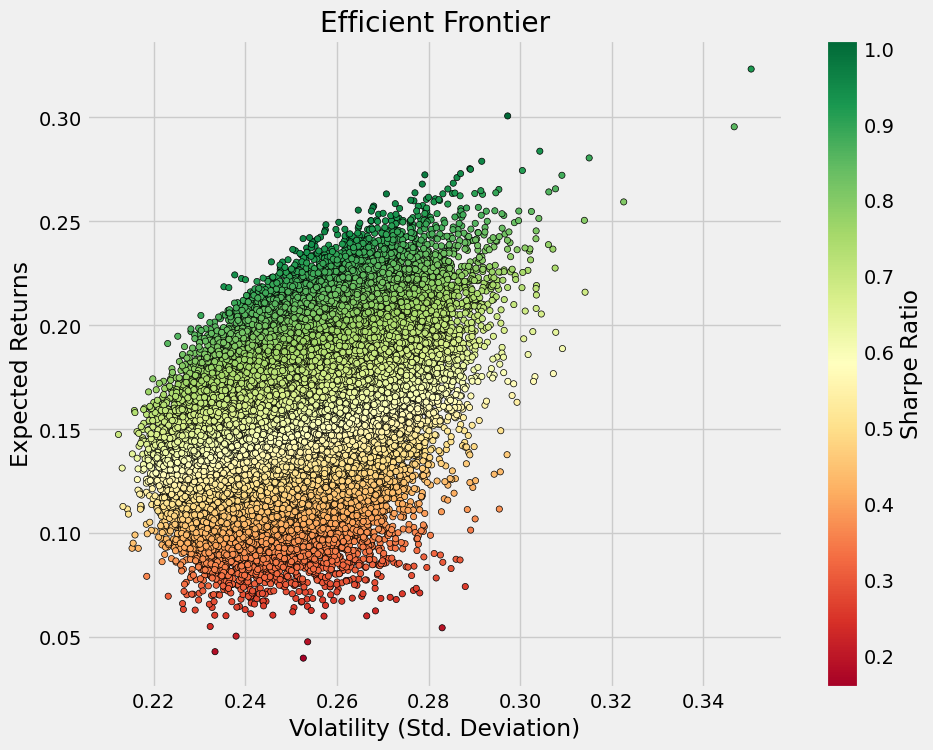

In [10]:
# PLotting the efficient frontier.
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

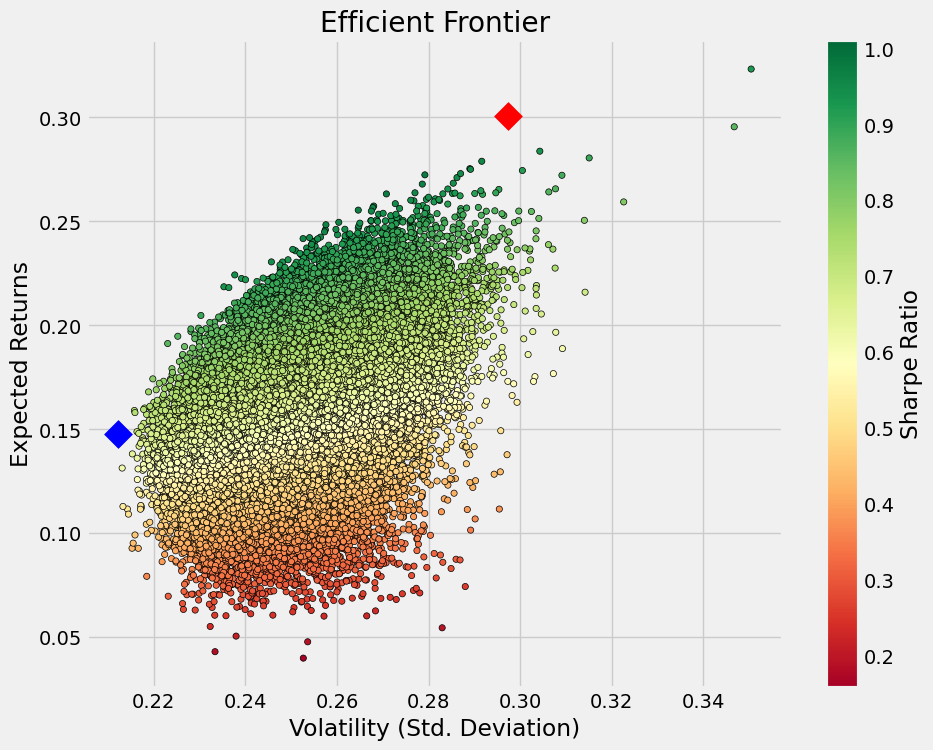

In [11]:
# Finding the Optimal Portfolio
min_volatility = df['Volatility'].min()
max_sharpe = df['Sharpe Ratio'].max()

# use the min, max values to locate and create the two special portfolios
sharpe_portfolio = df.loc[df['Sharpe Ratio'] == max_sharpe]
min_variance_port = df.loc[df['Volatility'] == min_volatility]

# plot frontier, max sharpe & min Volatility values with a scatterplot
plt.style.use('fivethirtyeight')
df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)
plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'], c='red', marker='D', s=200)
plt.scatter(x=min_variance_port['Volatility'], y=min_variance_port['Returns'], c='blue', marker='D', s=200 )
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

In [12]:
# Additional Details
r_ef = pd.concat([min_variance_port.T,sharpe_portfolio.T], axis = 1)
r_ef.columns = ["Minimum Risk Adjusted Values", "Max Risk Adjusted Values"]
print(r_ef)

              Minimum Risk Adjusted Values  Max Risk Adjusted Values
Returns                           0.147511                  0.300737
Volatility                        0.212267                  0.297289
Sharpe Ratio                      0.694931                  1.011599
GOOG Weight                       0.209187                  0.152743
NVDA Weight                       0.033875                  0.348306
META Weight                       0.009148                  0.030242
WFC Weight                        0.071051                  0.001756
DIS Weight                        0.095412                  0.006928
IMAX Weight                       0.015528                  0.129823
LUV Weight                        0.005229                  0.001439
PFE Weight                        0.335151                  0.074185
COKE Weight                       0.161293                  0.238556
CAT Weight                        0.064126                  0.016023


# If I were to invest 1,000 USD last year... what would I have now?

In [13]:
amount_invest = 1000
expected_return = pd.DataFrame(amount_invest * (1+r_ef.iloc[0,:]))
print("----------------------------------------------------------------")
print("                Expected Returns on my Portfolio")
print("----------------------------------------------------------------")
print(expected_return.T)
print("")
print("----------------------------------------------------------------")
print("If I invested", amount_invest,"USD on |", dT.index[0],"| I would have...")
actual_return = (dT.iloc[dT.shape[0]-1,:] - dT.iloc[0,:]) / ( dT.iloc[0,:])
# Multipling the weights to the price at the beginning of the year
beg_price = (dT.iloc[0,:])
end_price = dT.iloc[dT.shape[0]-1,:]
print("----------------------------------------------------------------")
# Weights derived from the Efficient Frontier Portfolio
# Weights for Minimum Risk
w = np.array(r_ef.iloc[3:,0])

percentage_change = (end_price - beg_price)/(beg_price)+1
print("Using the Portfolio Weights for Minimum Risk Return Portfolio")
money_left = sum(w * percentage_change* amount_invest)
print("")
print("    Starting balance $ 1000 : Ending with $ ",round(money_left, 2))
print("")
print("----------------------------------------------------------------")
print("Using the Portfolio Weights Maximized Risk-Return Portfolio")
# Weights for Maxmimum Risk
w1 = np.array(r_ef.iloc[3:,1])

money_left1 = sum(w1 * percentage_change* amount_invest)
print("")
print("    Starting balance $ 1000 : Ending with $ ", round(money_left1,2))
print("")


----------------------------------------------------------------
                Expected Returns on my Portfolio
----------------------------------------------------------------
         Minimum Risk Adjusted Values  Max Risk Adjusted Values
Returns                   1147.510943               1300.737462

----------------------------------------------------------------
If I invested 1000 USD on | 2023-10-11 00:00:00 | I would have...
----------------------------------------------------------------
Using the Portfolio Weights for Minimum Risk Return Portfolio

    Starting balance $ 1000 : Ending with $  1315.94

----------------------------------------------------------------
Using the Portfolio Weights Maximized Risk-Return Portfolio

    Starting balance $ 1000 : Ending with $  1947.06

